In [1]:
import os
os.chdir('../../scripts')
from analysis_tools_cython import *

In [2]:
df = pd.read_csv('/storage/astro2/phrdhx/tesslcs/sector6lookup.csv')

In [3]:
file = df.Filename[df.TIC_ID == 255641870].values[0]
print(file)

tesslcs_sector_6_104/tesslcs_tmag_11_12/tesslc_255641870.pkl


In [4]:
lc, lc_info = import_XRPlightcurve(os.path.join('/tmp/tess',file),sector=6)

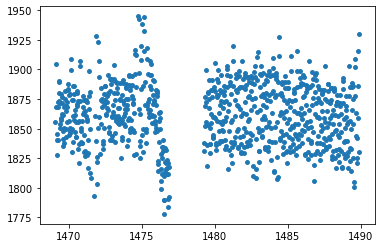

In [5]:
plt.scatter(lc['time'],lc['corrected flux'],s=15)

In [6]:
timestep = calculate_timestep(lc)
factor = ((1/48)/timestep)

In [7]:
lc['corrected flux'] = normalise_flux(lc['corrected flux'])

In [8]:
t, f, q, real, fe = clean_data(lc['time','corrected flux','quality','flux error'])

In [9]:
m,n,T1,minT,minT_time,minT_duration,Tm_start,Tm_end,Tm_depth,Ts = run_test_statistic(f,factor,timestep, t)

In [10]:
print(t[0])

1469.0542420802858


In [11]:
minT_time

1477.5126581324373

In [12]:
def check_consecutive_points(arr):
    consecutive_count = 1
    current_value = arr[0]

    for i in range(1, len(arr)):
        if arr[i] == current_value:
            consecutive_count += 1
        else:
            current_value = arr[i]
            consecutive_count = 1

        if consecutive_count == 10:
            return True
        else: 
            return False


In [32]:
def calc_shape(m,n,time,flux,quality,flux_error,n_m_bg_start=3,n_m_bg_scale_factor=1,non_normalised_flux=lc['corrected flux']*np.median(lc['corrected flux']),time_ori=lc.columns[0].data):
    """Fit both symmetric and comet-like transit profiles and compare fit.
    Returns:
    (1) Asymmetry: ratio of (errors squared)
    Possible errors and return values:
    -1 : Divide by zero as comet profile is exact fit
    -2 : Too close to edge of light curve to fit profile
    -3 : Unable to fit model (e.g. timeout)
    -4 : Too much empty space in overall light curve or near dip
    (2,3) Widths of comet curve fit segments.
    info: t, x, q, fit1 and fit2 are the transit shape elements 

    """
    ## how many transit widths to take the general linear trend from. start is 1/4 length of cutout from beginning, end is 1 from end.
    #first_index = n - (n_m_bg_start*n)
    #last_index = n - (n_m_bg_end*m)
    
    
    ## the transit widths of the cutout from the T-statistic minimum value. 
    ## this project requires the cutout to have more transit widths after the midtransit, to cover more of the tail.
    ## default is set to 1 transit width before and 2 transit widths after 

    n_m_bg_end = n_m_bg_scale_factor*n_m_bg_start

    cutout_before = n-(m*n_m_bg_start)
    cutout_after = n+(m*n_m_bg_end)

    if cutout_before >= 0 and cutout_after < len(time):
        t = time[cutout_before:cutout_after]
        if (t[-1]-t[0]) / np.median(np.diff(t)) / len(t) > 1.5:
            return -4,-4,-4,-4,-4,-4,-4, -4, -4, -4, -4, -4, -4
        t0 = time[n]
        diffs = np.diff(time_ori)#[time_ori[i + 1] - time_ori[i] for i in range(len(t) - 1)]
        #print(diffs[335:350])
                ### if a transit is less than 0.5 days within 2 days before or after transit centre, remove.
        for i,diff in enumerate(diffs):
            if diff > 0.5 and abs(t0-t[i])<2: # accounts for both sides of gap
                return -5,-5,-5,-5,-5,-5,-5, -5, -5, -5, -5
        
        
                
        x = flux[cutout_before:cutout_after]
        q = quality[cutout_before:cutout_after]
        fe = flux_error[cutout_before:cutout_after]
        
        bg_before = np.mean(x[:int(m/4)])
        bg_time_before = np.mean(t[:int(m/4)])
        bg_after = np.mean(x[-int(round(m/4)):])
        bg_time_after = np.mean(t[-int(round(m/4)):])
    


        grad = (bg_after-bg_before)/(bg_time_after-bg_time_before)
        background_level = bg_before + grad * (t - bg_time_before)
        x = x - background_level

        ### for the non-normalised flux 
        if non_normalised_flux is not None:
            nnx = non_normalised_flux[cutout_before:cutout_after]

        #    bg_before_nnx = np.mean(nnx[:int(m/4)])
        #    bg_after_nnx = np.mean(nnx[-int(round(m/4)):])

        #    grad_nnx = (bg_after_nnx-bg_before_nnx)/(bg_time_after-bg_time_before)
        #    background_level_nnx = bg_before_nnx + grad_nnx * (t - bg_time_before)
        #    nnx = nnx - background_level_nnx

        try:
            params1, pcov1 = single_gaussian_curve_fit(t,-x)
            #params2, pcov2 = comet_curve_fit(t,-x)
            if non_normalised_flux is not None:
                params3, pcov3 = skewed_gaussian_curve_fit(t,x,fe,flux=nnx)
                print(params3)
            else:
                params3, pcov3 = skewed_gaussian_curve_fit(t,x,fe)

           
        except:
            return -3,-3,-3,-3,-3,-3,-3, -3, -3, -3, -3

        fit1 = -gauss(t,*params1)
        #fit2 = -comet_curve(t,*params2)
        fit3 = skewed_gaussian(t,*params3)

        depth = fit3.min() # depth of comet (based on minimum point; not entirely accurate, but majority of the time true
        #min_time = t[np.argmin(x)] # time of midtransit/at minimum point
        ### reduced chi squared for the two models
        chisq_fit1 = chisquare(t,x,fit1,params1,fe)
        chisq_fit3 = chisquare(t,x,fit3,params3,fe)

        ### rmse, mae for both models
        rmse_fit3 = rmse(x,fit3)
        mae_fit3 = mae(x,fit3)

        plt.scatter(t,x,s=15)
        plt.scatter(t,fit3,s=15)
    
        scores = [score_fit(x,fit) for fit in [fit1,fit3]] # changed for the skewed gaussian fit
        if scores[1] > 0:
            skewness = params3[0]
            skewness_error = np.sqrt(np.diag(pcov3)[0])
            return scores[0]/scores[1], params3[2], params3[3], depth, [t,x,q,fe,fit1,fit3,background_level], skewness, skewness_error, chisq_fit1, chisq_fit3, rmse_fit3, mae_fit3
        else:

            return -1,-1,-1,-1,-1,-1,-1, -1, -1, -1, -1
    else:     

        return -2,-2,-2,-2,-2,-2,-2, -2, -2, -2, -2

In [33]:
calc_shape(m,n,t,f,q,fe)


(-5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5)

In [36]:
li = [ lc[i+1][0] - lc[i][0] for i in range(len(lc)-1) ]
indices = [i for i in range(len(li)) if li[i] > 2.375]
indices


TypeError: len() takes exactly one argument (12 given)